#Prepare the workbench

In [45]:
!pip3 install emoji #used to remove emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=ab08608e3ea68196bcc197112d4bb3d5d06bd17ce52ac508561a76b3c5ff49c0
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [ ]:
!git clone https://github.com/rwalk/gsdmm.git gsdmm #used for topic modelling of short texts

In [ ]:
!python -m spacy download pl_core_news_sm 

In [47]:
import shutil
import pandas as pd
import re
import emoji
import nltk
import gensim
from nltk.stem import WordNetLemmatizer
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import gsdmm
from gsdmm.gsdmm import MovieGroupProcess
from tqdm import tqdm# convert string of tokens into tokens list
# import library from gensim  
from gensim.models import CoherenceModel
# import library from gensim  
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import spacy

In [ ]:
nlp = spacy.load("pl_core_news_sm")

#Get data

In [ ]:
from google.colab import files
uploaded = files.upload()

In [48]:
shutil.unpack_archive('tweety_rekrutacja.zip')

In [49]:
twitter_data = pd.read_csv('tweety_rekrutacja.csv')

In [ ]:
twitter_data.head()

In [ ]:
twitter_data.info()

In [ ]:
#train_data = twitter_data.sample(frac=0.1, random_state=42) used to test functions on smaller data

# Clean tweets

In [ ]:
stopwords = nlp.Defaults.stop_words

In [ ]:
# define a string of punctuation symbols
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@...'

In [ ]:
included_tags = {"NOUN", "ADJ", "ADV", "ADP", "PROPN"} #not all sentence parts are useful in topic modelling

In [ ]:
# functions to clean tweets

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet


def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet


def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet


def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet


def remove_stop_words(tweet):
  """Takes a string and removes stop words"""
  no_stop_words =[]
  for word in tweet.split():
      if word.lower() not in stopwords:  
          no_stop_words.append(word)
  tweet = ' '.join(no_stop_words)
  return tweet                   
        
def lemmatize(tweet):
  """Takes a string and lemmatize it"""
  doc = nlp(tweet)
  lemma = []
  for token in doc:
      #print(token.text, token.pos_, token.dep_, token.lemma_)
      lemma.append(token.lemma_)
  tweet = ' '.join(lemma)
  return tweet


def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = emoji.replace_emoji(tweet)
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = remove_stop_words(tweet)
    tweet = lemmatize(tweet)
    #tweet = re.sub('...', ' ', tweet)
    return tweet

def include_tags(tweet):
  """Takes a string and left only included tags"""
  doc = nlp(tweet)
  incl_words = []
  for token in doc:
      #print(token.text, token.pos_, token.dep_, token.lemma_)
      if token.pos_ in included_tags:
        incl_words.append(token.text)
  tweet = ' '.join(incl_words)
  return tweet

In [ ]:
#train_data['full_text_cleaned'] = train_data['full_text'].apply(preprocess_tweet) #on 10% data it takes in basic colab it takes 1min

In [ ]:
twitter_data['full_text_cleaned'] = twitter_data['full_text'].apply(preprocess_tweet) #in basic colab it takes 17min

In [ ]:
twitter_data['full_text_cleaned_tm'] = twitter_data['full_text_cleaned'].apply(include_tags) #with selected speech parts | in basic colab it takes 16min

# Q1  What topics can we see in the texts (what are people writing about)?

## Gibbs Sampling Dirichlet Mixture Model

The specific model we will use for STTM is Gibbs Sampling Dirichlet Mixture Model (GSDMM) which is a modified LDA algorithm that uses the simple assumption of one topic assigned to one text.

Our tokens are converted into a list and then create a final list of lists to hold all the tokens across all of tweets. This is necessary as it is the proper input format for the model.

In [ ]:
#excluding_verbs
twitter_data['full_text_tokens'] = twitter_data['full_text_cleaned_tm'].apply(lambda x: re.split('\s', x))# create list of  token lists
docs = twitter_data['full_text_tokens'].tolist()

In [ ]:
#including_verbs
#train_data['full_text_tokens'] = train_data['full_text_cleaned'].apply(lambda x: re.split('\s', x))# create list of  token lists
#docs = train_data['full_text_tokens'].tolist()

## Train inital GSDMM

Hyper-parameters for GSDMM:

- **K** — Represents the number of maximum topics that will be found by the model. 
- **Alpha α** — In regards to the MGP, alpha controls a factor that decides how easily a table gets removed when it’s empty (low alpha = fewer tables). As a result, the number of non-empty clusters will get larger as alpha increases and there will be more clusters with only one or few documents. By default, a value of `α=0.1`works fine on most datasets.
- **Beta β** — In regards to the MGP, beta controls how a table is chosen for a student based on similarity to the table rather than the popularity of the table (low beta = more similar clusters). As a result, the number of non-empty clusters will get smaller as beta increases since the model will give more emphasis on selecting popular clusters rather than similar clusters. By default, a value of `β=0.1`works fine on most data sets.
- **N_iters** — In regards to the MGP, this represents the number of iterations or number of times that each student is reassigned to a new table by the professor. According to the [original research paper](https://dl.acm.org/doi/10.1145/2623330.2623715), GSDMM converges fairly quickly and stability is generally reached within 10 though we will use `n_iters=30`as our default.

In [ ]:
#the best k will be found 
alpha_v = 0.1
beta_v = 0.1
n_iters_v = 10

In order to assess our clusters the coherence of clusters will be calculated.

The coherence value will be used to find the best number o k and to compare GSDMM to LDA

It is calculate with gensim and requires initialization of below variables:

In [ ]:
id2word = corpora.Dictionary(docs)
texts = docs
corpus = [id2word.doc2bow(text) for text in texts]

Gensim does not have a function to directly calculate coherence for clusters found with gsdmm model. Therefore there is a need to find topics list first in additional function

In [ ]:
# define function to get words in topics
def get_topics_lists(model, top_clusters, n_words):
    '''
    Gets lists of words in topics as a list of lists.
    
    model: gsdmm instance
    top_clusters:  numpy array containing indices of top_clusters
    n_words: top n number of words to include
    
    '''
    # create empty list to contain topics
    topics = []
    
    # iterate over top n clusters
    for cluster in top_clusters:
        #create sorted dictionary of word distributions
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]
         
        #create empty list to contain words
        topic = []
        
        #iterate over top n words in topic
        for k,v in sorted_dict:
            #append words to topic list
            topic.append(k)
            
        #append topics to topics list    
        topics.append(topic)
    
    return topics

### Find the best number of clusters

In [ ]:
def calc_coherence_values_gsdmm(dictionary,corpus, texts, limit, start, step, n_words, alpha, beta, n_iters):
    coherence_values = []
    model_list = []
    vocab = set(x for doc in texts for x in doc)
    n_terms = len(vocab)
    for num_topics in range(start, limit, step):
        mgp = MovieGroupProcess(K=num_topics, alpha=alpha, beta=beta, n_iters=n_iters)
        model = mgp.fit(docs, n_terms)
        #model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1] # topics sorted by the number of document they are allocated to
        topics = get_topics_lists(mgp, top_index, n_words= n_words)
        coherencemodel = CoherenceModel(topics = topics, corpus = corpus, dictionary = id2word, coherence = 'c_v', texts = texts)
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

The above defined funtion is used to train gsdmm model, find clusters and calculate coherence for them

It checks coherence for every 2 number of clusters ranged from 3 to 10.  

In [ ]:
model_list, coherence_values = calc_coherence_values_gsdmm(dictionary = id2word, texts = texts, start = 2, corpus = corpus, n_words=10, 
                                                           limit = 10, step = 2, alpha = alpha_v, beta = beta_v, n_iters = n_iters_v)

In stage 0: transferred 41684 clusters with 2 clusters populated
In stage 1: transferred 27409 clusters with 2 clusters populated
In stage 2: transferred 20414 clusters with 2 clusters populated
In stage 3: transferred 16071 clusters with 2 clusters populated
In stage 4: transferred 13392 clusters with 2 clusters populated
In stage 5: transferred 11240 clusters with 2 clusters populated
In stage 6: transferred 10135 clusters with 2 clusters populated
In stage 7: transferred 9281 clusters with 2 clusters populated
In stage 8: transferred 8682 clusters with 2 clusters populated
In stage 9: transferred 8405 clusters with 2 clusters populated
model created
0.2706663632192144
In stage 0: transferred 62957 clusters with 4 clusters populated
In stage 1: transferred 42116 clusters with 4 clusters populated
In stage 2: transferred 30872 clusters with 4 clusters populated
In stage 3: transferred 23123 clusters with 4 clusters populated
In stage 4: transferred 18373 clusters with 4 clusters popul

In [ ]:
#excluding verbs
max(coherence_values)

0.4315933245726853

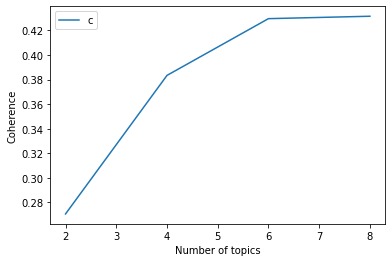

In [ ]:
#including verbs
limit, start, step = 10, 2, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

Coherence of clusters increases with number of topics.

After reaching 6 clusters the increase slows down.

6 topics also seems as an actionable number of the clusters, **so analyze will be continued with 6 topics**

### GSDMM vs LDA

Latent Dirichlet Allocation (LDA) is a generative probabilistic model algorithm that uncovers latent variables that govern the semantics of a document, these variables representing abstract topics.

LDA may not work well with shorter texts (< 50 words) such as tweets, because  of these key characteristics:

- Each short text lacks enough word co-occurrence information. **Word co-occurrence** is the chance that two words occur together in a text and it helps with inferring the word distribution of topics generated.
- Most topics are probably generated by only 1 topic due to containing minimal words.
- Statistical information of words among texts cannot fully capture words that are semantically related but rarely co-occur.

Since tweets vary from few words to over 100 words texts, LDA perfomance will be checked below

In [ ]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values_lda = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values_lda.append(coherencemodel.get_coherence())
    return model_list, coherence_values_lda

In [ ]:
model_list, coherence_values_lda = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 1, limit = 10, step = 2)

model created
0.23955329512361337
model created
0.247275965198931
model created
0.2680176700849859
model created
0.2438870284105819
model created
0.2727376607537022


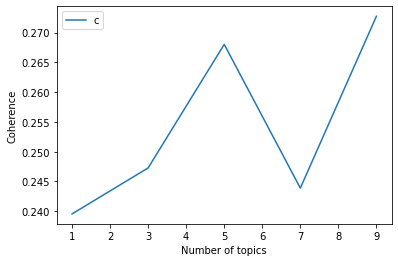

In [ ]:
limit, start, step = 10, 1, 2
x = range(start, limit, step)
plt.plot(x, coherence_values_lda)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values_lda"), loc='best')
plt.show()

## Train final GSDMM model


In [ ]:
k_v = 6
alpha_v = 0.1
beta_v = 0.1
n_iters_v = 10

In [ ]:
# train STMM model
mgp = MovieGroupProcess(K=k_v, alpha=alpha_v, beta=beta_v, n_iters=n_iters_v)
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)
model = mgp.fit(docs, n_terms)# save model
with open('6clusters.model', 'wb') as f:
 pickle.dump(model, f)
 f.close()

In stage 0: transferred 70855 clusters with 6 clusters populated
In stage 1: transferred 47954 clusters with 6 clusters populated
In stage 2: transferred 34386 clusters with 6 clusters populated
In stage 3: transferred 25220 clusters with 6 clusters populated
In stage 4: transferred 20316 clusters with 6 clusters populated
In stage 5: transferred 17122 clusters with 6 clusters populated
In stage 6: transferred 14973 clusters with 6 clusters populated
In stage 7: transferred 13621 clusters with 6 clusters populated
In stage 8: transferred 12830 clusters with 6 clusters populated
In stage 9: transferred 12255 clusters with 6 clusters populated


In [ ]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [ ]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)

# topics sorted by the number of documents they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

# show the top 5 words in term frequency for each cluster 
topic_indices = np.arange(start=0, stop=len(doc_count), step=1)
top_words(mgp.cluster_word_distribution, topic_indices, 5)

Number of documents per topic : [15018 22161 13117  4000 14078 24264]
********************
Most important clusters (by number of docs inside): [5 1 0 4 2 3]
********************

Cluster 0 : [('gaz', 7930), ('węgiel', 5230), ('cena', 2667), ('ropa', 2654), ('rosja', 2636)]

Cluster 1 : [('węgiel', 23565), ('tona', 3296), ('złoty', 2889), ('pis', 2634), ('rząd', 2616)]

Cluster 2 : [('atomowy', 5400), ('elektrownia', 3755), ('inflacja', 3749), ('węgiel', 2382), ('Polska', 1830)]

Cluster 3 : [('pis', 2873), ('cena', 2163), ('węgiel', 2136), ('podwyżka', 1873), ('prąd', 1497)]

Cluster 4 : [('węgiel', 6430), ('inflacja', 4173), ('cena', 1779), ('pis', 1630), ('węglowy', 1395)]

Cluster 5 : [('inflacja', 14559), ('cena', 13389), ('energia', 4094), ('rok', 3770), ('wzrost', 2443)]


In [ ]:
def topic_allocation(df, docs, mgp, topic_dict):
    '''allocates all topics to each document in original dataframe,
    adding two columns for cluster number and cluster description'''
    topic_allocations = []
    for doc in tqdm(docs):
        topic_label, score = mgp.choose_best_label(doc)
        topic_allocations.append(topic_label)

    df['cluster'] = topic_allocations

    df['topic_name'] = df.cluster.apply(lambda x: get_topic_name(x, topic_dict))
    print('Complete. Number of documents with topic allocated: {}'.format(len(df)))

def get_topic_name(doc, topic_dict):
    '''returns the topic name string value from a dictionary of topics'''
    topic_desc = topic_dict[doc]
    return topic_desc

In [ ]:
# define dictionary topics in same sequential order
# as resulting clusters from gsdmm model 
topic_dict = {}
topic_names = ['energy_resources',
               'coal',
               'nuclear_energy',
               'energy_prices',
               'coal_prices',
               'inflation'
               ]

for i, topic_num in enumerate(topic_indices):
    topic_dict[topic_num]=topic_names[i]
    
# allocate topics to original data frame 
topic_allocation(twitter_data, docs, mgp, topic_dict)

100%|██████████| 92638/92638 [00:18<00:00, 5074.13it/s]


Complete. Number of documents with topic allocated: 92638


In [ ]:
twitter_data.to_csv('twitter_data.csv',index=True)

In [ ]:
from google.colab import files
files.download('twitter_data.csv')

In [ ]:
files.download('6clusters.model')

## Visualize results

In [ ]:
import plotly.express as px

In [ ]:
twitter_data = pd.read_csv('twitter_data.csv')

In [ ]:
twitter_data.columns

Index(['Unnamed: 0', 'name', 'created_at', 'id', 'id_str', 'full_text',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'geo', 'is_quote_status', 'retweet_count',
       'favorite_count', 'possibly_sensitive', 'lang', 'quoted_status_id',
       'quoted_status_id_str', 'quote_count', 'reply_count',
       'full_text_cleaned', 'full_text_cleaned_tm', 'full_text_tokens',
       'cluster', 'topic_name'],
      dtype='object')

In [ ]:
fig = px.pie(twitter_data['topic_name'], names='topic_name',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [ ]:
twitter_data['len'] = twitter_data['full_text'].apply(lambda row: len(row.split()))

In [ ]:
import seaborn as sns

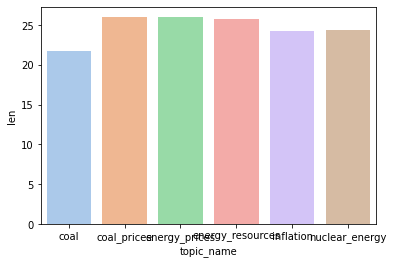

In [ ]:
types_len = twitter_data.groupby(by=['topic_name']).mean()
types = sns.barplot(x = types_len.index, y = types_len['len'], palette="pastel")

In [ ]:
from wordcloud import WordCloud 

In [ ]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

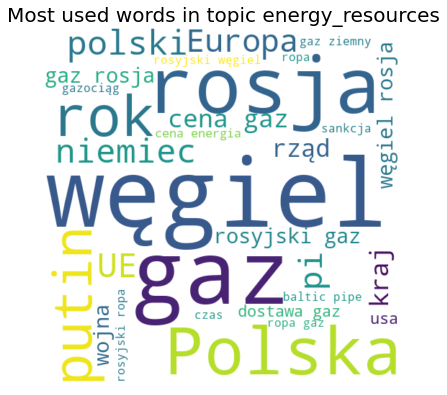

In [ ]:
create_WordCloud(twitter_data['full_text_cleaned_tm'].loc[twitter_data['topic_name'] == 'energy_resources'], title="Most used words in topic energy_resources")

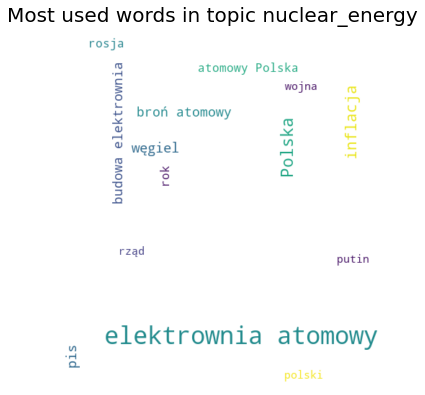

In [ ]:
create_WordCloud(twitter_data['full_text_cleaned_tm'].loc[twitter_data['topic_name'] == 'nuclear_energy'], title="Most used words in topic nuclear_energy")

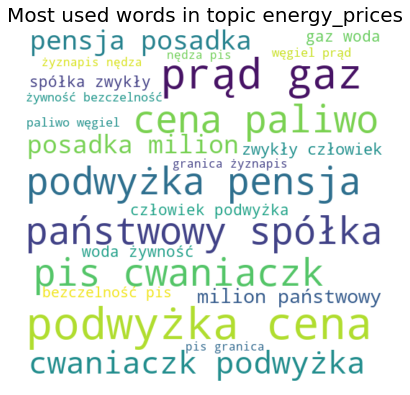

In [ ]:
create_WordCloud(twitter_data['full_text_cleaned_tm'].loc[twitter_data['topic_name'] == 'energy_prices'], title="Most used words in topic energy_prices")

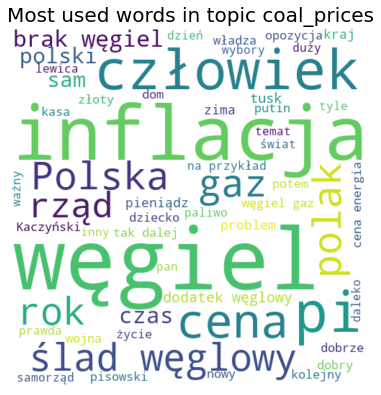

In [ ]:
create_WordCloud(twitter_data['full_text_cleaned_tm'].loc[twitter_data['topic_name'] == 'coal_prices'], title="Most used words in topic coal_prices")

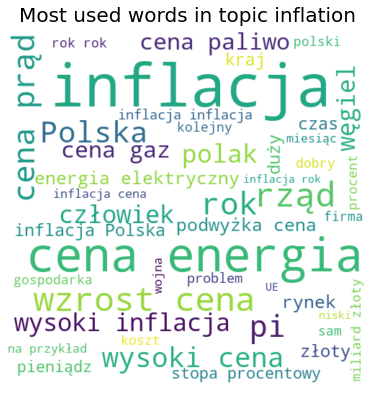

In [ ]:
create_WordCloud(twitter_data['full_text_cleaned_tm'].loc[twitter_data['topic_name'] == 'inflation'], title="Most used words in topic inflation")

#Q2 What are the most important users who initiate discussions in specific topics?

Approach:
1. calculate a few measures which may be useful for assesing who is important user. These measureas are: number times the user was quoted and how many replies she got.
2. Aggregate measures for users.
3. Check different measures for selected topics

In [ ]:
rl = list(twitter_data['quoted_status_id_str'])

In [ ]:
twitter_data['quotation_n'] = twitter_data['id_str'].apply(lambda x: rl.count(x))

In [ ]:
in_reply_to_status_id_str_list = list(twitter_data['in_reply_to_status_id_str'])

In [ ]:
twitter_data['reply_n'] = twitter_data['id_str'].apply(lambda x: in_reply_to_status_id_str_list.count(x))

In [ ]:
twitter_data_q2 = twitter_data.groupby(['topic_name','name']).agg(
    replied = pd.NamedAgg(column='reply_n', aggfunc='sum'),
    quoted = pd.NamedAgg(column='quotation_n', aggfunc='sum'),
    replies_given = pd.NamedAgg(column='in_reply_to_status_id_str', aggfunc='count'),
    retweeted = pd.NamedAgg(column='retweet_count', aggfunc='sum'),
    favorited = pd.NamedAgg(column='favorite_count', aggfunc='sum'),
    number_of_tweets = pd.NamedAgg(column='name', aggfunc='size')
)

In [ ]:
twitter_data_q2['orginal_tweet'] = twitter_data_q2['number_of_tweets'] - twitter_data_q2['replies_given']

## Coal influencers

It is a matter of discussion what is the best measure of leader, topic starter. 

One can argue that the most important is how many person tweet were retweeted.

In case of coal topi ania_curly has the highest number

In [ ]:
coal_influencers = twitter_data_q2.iloc[twitter_data_q2.index.get_level_values('topic_name') == 'coal']

In [ ]:
coal_influencers

replied  quoted  replies_given  retweeted  favorited  \
topic_name name                                                                
coal       13Ra_Dek37         0       0              2          0          0   
           1968Kawabis        0       0              2       2605         24   
           1972tomek          7       1              0        600       4285   
           1980Radek          3       0              0         50        369   
           1Dydek             0       0              7          9         50   
...                         ...     ...            ...        ...        ...   
           zibi_koss          0       0              1         83        475   
           zolkaa73           0       0              1       3388          3   
           zujpaszcza         0       0              1          0          1   
           zwyklyPolak        0       0              1       1157          6   
           zwykly_ja          0       0              3         24        208   

                        number_of_tweets  orginal_tweet  
topic_name name                                          
coal       13Ra_Dek37                  2              0  
           1968Kawabis                16             14  
           1972tomek                  17             17  
           1980Radek                   4              4  
           1Dydek                     15              8  
...                                  ...            ...  
           zibi_koss                   7              6  
           zolkaa73                   22             21  
           zujpaszcza                  1              0  
           zwyklyPolak                 9              8  
           zwykly_ja                   8              5  

[1800 rows x 7 columns]

## Energy resources influencers

One can argue that the most important is how many person tweets were marked as favorite.

In case of energy_resources topic wjakobik has the highest number

In [ ]:
energy_resources_influencers = twitter_data_q2.iloc[twitter_data_q2.index.get_level_values('topic_name') == 'energy_resources']

In [ ]:
energy_resources_influencers

replied  quoted  replies_given  retweeted  \
topic_name       name                                                        
energy_resources 13Ra_Dek37            0       0              2         65   
                 1968Kawabis           0       0              3       1958   
                 1972tomek             8       1              0        588   
                 1980Radek             0       0              1          5   
                 1Dydek                1       0             13          0   
...                                  ...     ...            ...        ...   
                 zelazna_logika        0       0              2         33   
                 zer0_pl               0       0              1          0   
                 zolkaa73              0       0              0       2594   
                 zwyklyPolak           0       0              0        517   
                 zwykly_ja             0       0              3          0   

                                 favorited  number_of_tweets  orginal_tweet  
topic_name       name                                                        
energy_resources 13Ra_Dek37              0                 3              1  
                 1968Kawabis            13                13             10  
                 1972tomek            4277                17             17  
                 1980Radek              23                 3              2  
                 1Dydek                 28                15              2  
...                                    ...               ...            ...  
                 zelazna_logika        556                 3              1  
                 zer0_pl                10                 1              0  
                 zolkaa73                0                 7              7  
                 zwyklyPolak             0                 9              9  
                 zwykly_ja               0                 3              0  

[1755 rows x 7 columns]

## Nuclear energy influencers

In [ ]:
nuclear_energy_influencers = twitter_data_q2.iloc[twitter_data_q2.index.get_level_values('topic_name') == 'nuclear_energy']

In [ ]:
nuclear_energy_influencers

replied  quoted  replies_given  retweeted  \
topic_name     name                                                     
nuclear_energy 13Ra_Dek37         0       0              1          0   
               1968Kawabis        0       0              2       1888   
               1972tomek          6       1              0       1406   
               1980Radek          0       0              1        197   
               1Dydek             0       0              7          1   
...                             ...     ...            ...        ...   
               zibi_koss          1       0              1          0   
               zolkaa73           0       0              0       1566   
               zujpaszcza         0       0              3          1   
               zwyklyPolak        0       0              0        581   
               zwykly_ja          0       0              4          0   

                            favorited  number_of_tweets  orginal_tweet  \
topic_name     name                                                      
nuclear_energy 13Ra_Dek37           4                 1              0   
               1968Kawabis         12                12             10   
               1972tomek         7823                17             17   
               1980Radek          887                 4              3   
               1Dydek              22                14              7   
...                               ...               ...            ...   
               zibi_koss            0                 2              1   
               zolkaa73             0                 8              8   
               zujpaszcza          85                 5              2   
               zwyklyPolak          0                 4              4   
               zwykly_ja           49                 5              1   

                            success_rate  
topic_name     name                       
nuclear_energy 13Ra_Dek37       0.250000  
               1968Kawabis      0.006316  
               1972tomek        0.001842  
               1980Radek        0.003690  
               1Dydek           0.608696  
...                                  ...  
               zibi_koss             inf  
               zolkaa73         0.005109  
               zujpaszcza       0.058140  
               zwyklyPolak      0.006885  
               zwykly_ja        0.102041  

[1759 rows x 8 columns]

# Q4 How can we identify inauthentic accounts which could possibly be bots or trolls?

Approach:
1. fine-tune a Transformer model on labeled dataset
2. Use model to predict whether tweets are troll-like
3. If the account has share of troll-like tweets sinificantly higher than tweets' authors population point the account as a troll one 

Simple Transformers - an NLP library based on the Transformers library by HuggingFace will be used. Simple Transformers allow to fine-tune Transformer models in a few lines of code.

Two datasets will be used:

1. FiveThirtyEight's 3 million Russian troll tweets dataset available at kaggle: https://www.kaggle.com/datasets/fivethirtyeight/russian-troll-tweets
2. since the FiveThirtyEight's dataset consist only of troll tweets it will be subsituted by dataset with not troll tweets - manually labelled 1000 most popular tweets (twits_annotated.xlsx) with cathegories is_fake (categorical and numeric) topic and sentiment available at: https://zenodo.org/record/4319813#.Y9AxcHbMI2x  


## Prepare a workbench

In [2]:
# install simpletransformers
!pip install simpletransformers
# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2
!pip install spacy-language-detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 113.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 120.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

simpletransformers==0.63.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=cf4f7b9a9eb0a49e7406205c53559e3018b196650fb22e3f32177973829f1cb6
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [3]:
import pandas as pd 
import glob
import os
import collections as clln
import numpy as np
import re
from string import punctuation, whitespace
import matplotlib.pyplot as plt
import multiprocessing as mp
#import ftfy
import warnings
from sklearn.cluster import DBSCAN
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
import shutil

## Datasets preparation


### FiveThirtyEight's troll tweets dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
os.mkdir('ru_troll_tweets')

In [ ]:
shutil.unpack_archive('archive.zip', 'ru_troll_tweets')

In [ ]:
#print(os.listdir("../input/russian-troll-tweets"))
PATH = "ru_troll_tweets"
filenames = glob.glob(os.path.join(PATH, "*.csv"))
full_ru_trolls = pd.concat((pd.read_csv(f) for f in filenames))

In [ ]:
full_ru_trolls.columns

Index(['external_author_id', 'author', 'content', 'region', 'language',
       'publish_date', 'harvested_date', 'following', 'followers', 'updates',
       'post_type', 'account_type', 'new_june_2018', 'retweet',
       'account_category'],
      dtype='object')

In [ ]:
full_ru_trolls['language'].unique()

array(['Russian', 'Ukrainian', 'Bulgarian', 'Macedonian', 'Serbian',
       'Uzbek', 'LANGUAGE UNDEFINED', 'English', 'Dutch', 'Norwegian',
       'Farsi (Persian)', 'Spanish', 'Croatian', 'French', 'Somali',
       'Polish', 'Swedish', 'Romanian', 'Albanian', 'Vietnamese',
       'Lithuanian', 'Arabic', 'German', 'Japanese', 'Italian',
       'Estonian', 'Catalan', 'Portuguese', 'Pushto', 'Icelandic',
       'Finnish', 'Latvian', 'Tagalog (Filipino)', 'Greek', 'Hebrew',
       'Kurdish', 'Malay', 'Czech', 'Indonesian', 'Turkish', 'Slovak',
       'Danish', 'Hungarian', 'Korean', 'Slovenian', 'Urdu', 'Hindi',
       'Simplified Chinese', 'Thai', 'Bengali', 'Traditional Chinese',
       'Gujarati', 'Kannada', 'Tamil', 'Telugu', 'Malayalam'],
      dtype=object)

Fine tunnig will be on exlusively polish language tweets

In [ ]:
full_ru_trolls_pl = full_ru_trolls.loc[full_ru_trolls['language'] == 'Polish']

In [ ]:
full_ru_trolls_pl['content']

19139     Meadowlark Lemon, famed hoops jester, dies  #s...
262578    #NowPlaying: "Warzone (Dirty)" T.I. - https://...
266845          Snowy Wedding Pic 2 https://t.co/v1cdle0mcW
296843    '@9GAG "drunk? who's drunk?" https://t.co/V6w8...
299258                   '@kellie_scott it's winter, baby!'
                                ...                        
329485    icy-hot @bellalococo penny @deserving_death Je...
332867    .@RadioGaffney podcast w/ @elanjourno @rpolloc...
343057    Ciclismo, Milano-Sanremo a Kwiatkowski: Sagan ...
363313    16 days workout za mna ?wiczymyrazem @IAMMISSC...
366545                       Prawn Connery #famouscreatures
Name: content, Length: 386, dtype: object

#### Language detector

One can see that variable 'language' is not dependable. Therefore language detector will be built

In [ ]:
def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)  # We use the seed 42

nlp_model = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)

In [ ]:
def detect_language(tweet):
  """Takes a string and detect probability of language used"""
  doc = nlp_model(tweet)
  tweet = doc._.language 
  return tweet

In [ ]:
full_ru_trolls['lan_detected'] = full_ru_trolls['content'].apply(detect_language)

In [ ]:
full_ru_trolls_pl = full_ru_trolls.loc[full_ru_trolls['lan_detected'] == 'pl']

In [ ]:
#full_ru_trolls_pl = full_ru_trolls.loc[full_ru_trolls['language'] == 'Polish']

In [ ]:
full_ru_trolls_pl.to_csv('full_ru_trolls_pl.csv',index=True)

In [13]:
#full_ru_trolls_pl = pd.read_csv('full_ru_trolls_pl.csv')

### Annotated dataset

In [ ]:
from google.colab import files
files.upload()

In [8]:
tweet_ann = pd.read_excel('twits_annotated.xlsx', header = 1)

In [9]:
tweet_ann['account_category'] = tweet_ann['FAKE tak/nie/moze/ odniesienie/trudno'].apply(lambda x: 1 if(x == 'tak') else 0)

In [10]:
tweet_ann = tweet_ann[['tekst', 'account_category']]

In [11]:
tweet_ann.rename(columns = {'tekst':'content'} , inplace = True)

In [15]:
df = full_ru_trolls_pl[['content','account_category']]

In [ ]:
df['account_category'] = 1

In [17]:
df = pd.concat([df, tweet_ann])

##Model fine-tuning

In [18]:
train_df, test_df = train_test_split(df, test_size=0.10)

The next step is to load the pre-trained model.

1. the architecture is in our case "bert"
2. the pre-trained model ("dkleczek/bert-base-polish-cased-v1") available on https://huggingface.co/dkleczek/bert-base-polish-cased-v1
3. the number of class labels (4)
4. hyperparameter for training (train_args).

In [20]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "fp16":False,
             "num_train_epochs": 4}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "dkleczek/bert-base-polish-cased-v1",
    num_labels=2,
    args=train_args,
    use_cuda = False
)

Downloading:   0%|          | 0.00/459 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/531M [00:00<?, ?B/s]

Some weights of the model checkpoint at dkleczek/bert-base-polish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

Downloading:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
model.train_model(train_df)

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1247 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/156 [00:00<?, ?it/s]

(624, 0.27131901493442295)

##Model evaluation

In [22]:
from sklearn.metrics import f1_score, accuracy_score
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_score, acc=accuracy_score)

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/139 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/18 [00:00<?, ?it/s]

In [24]:
result

{'mcc': 0.817524780962326,
 'tp': 36,
 'tn': 92,
 'fp': 2,
 'fn': 9,
 'auroc': 0.9576832151300236,
 'auprc': 0.9443616339386053,
 'f1': 0.8674698795180723,
 'acc': 0.920863309352518,
 'eval_loss': 0.2848568341254981}

## Model saving

In [26]:
import os
import tarfile

def save_model(model_path='',file_name=''):
  files = [files for root, dirs, files in os.walk(model_path)][0]
  with tarfile.open(file_name+ '.tar.gz', 'w:gz') as f:
    for file in files:
      f.add(f'{model_path}/{file}')

In [28]:
save_model('outputs','bert-dkleczek-bert-base-polish-cased')

In [30]:
!tar -zxvf bert-dkleczek-bert-base-polish-cased.tar.gz

outputs/pytorch_model.bin
outputs/model_args.json
outputs/tokenizer.json
outputs/eval_results.txt
outputs/training_args.bin
outputs/special_tokens_map.json
outputs/tokenizer_config.json
outputs/vocab.txt
outputs/config.json


## Predictions with trained model

In [31]:
import os
import tarfile

def unpack_model(model_name=''):
  tar = tarfile.open(f"{model_name}.tar.gz", "r:gz")
  tar.extractall()
  tar.close()

In [36]:
unpack_model('bert-dkleczek-bert-base-polish-cased')

In [39]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "fp16":False,
             "num_train_epochs": 4}

# Create a ClassificationModel with our trained model
model_loaded = ClassificationModel(
    "bert", 'outputs/',
    num_labels=2,
    args=train_args,
    use_cuda = False
)

In [40]:
def predict_tweet_class(tweet):
  """Take a string and with trained model predict whether the tweet is troll-like"""
  predictions, raw_outputs = model_loaded.predict([tweet])
  return predictions

In [ ]:
twitter_data['tweet_class'] = twitter_data['full_text'].apply(predict_tweet_class)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Find users with higher than average number of troll-like tweets

In [ ]:
grouped = twitter_data.groupby('name')

In [ ]:
grouped2 = grouped['tweet_class'].agg(np.mean)

In [ ]:
grouped2.columns = ['name', 'class_avg']

In [ ]:
g2 = grouped2.to_frame()

In order to find users with abnormally high number of troll like tweets z-score is calculated

In [ ]:
# Z score
from scipy import stats
import numpy as np
 
z = stats.zscore(g2['tweet_class']) #it is not np.abs(stats.zscore(g2['tweet_class'])) because we use only users with high score 


Now to define an outlier threshold value is chosen which is generally 3.0. As 99.7% of the data points lie between +/- 3 standard deviation (using Gaussian Distribution approach).

In [ ]:
print(np.where(z > 3))